**Импортируем необходимые библиотеки и проведем первичный анализ данных**

   Unnamed: 0  user id test group  converted  total ads most ads day  \
0           0  1069124         ad      False        130       Monday   
1           1  1119715         ad      False         93      Tuesday   
2           2  1144181         ad      False         21      Tuesday   
3           3  1435133         ad      False        355      Tuesday   
4           4  1015700         ad      False        276       Friday   

   most ads hour  
0             20  
1             22  
2             18  
3             10  
4             14  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null

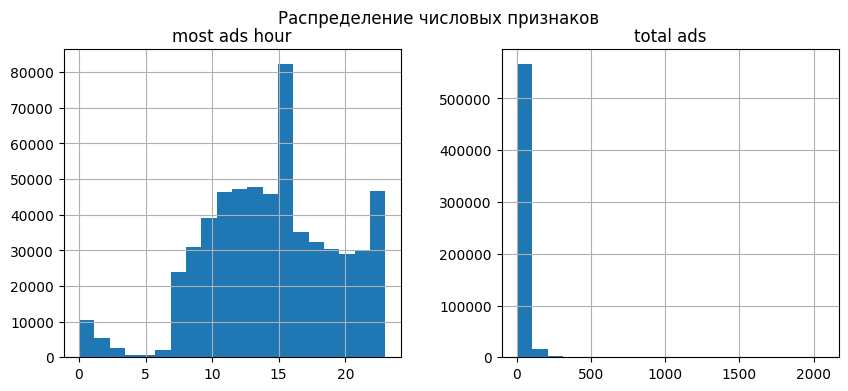

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("marketing_AB.csv")


print(df.head())
print(df.info())
print(df.describe())
num_cols = ['most ads hour', 'total ads']
df[num_cols].hist(bins=20, figsize=(10,4))
plt.suptitle('Распределение числовых признаков')
plt.show()

In [12]:
# Приведение типов данных к более подходящим
df = df.astype({
    'test group': 'category',
    'converted': 'bool',
    'most ads day': 'category',
    'most ads hour': 'int64',
    'total ads': 'int64'
})

print(df.dtypes)

Unnamed: 0          int64
user id             int64
test group       category
converted            bool
total ads           int64
most ads day     category
most ads hour       int64
dtype: object


Типы столбцов приведены к оптимальным для анализа и вычислений.

**Анализ пересечений пользователей.**

In [13]:
dupe_users = df.groupby('user id')['test group'].nunique()
ambiguous = dupe_users[dupe_users > 1]

print(f"Пользователи в обеих группах: {len(ambiguous)}")

Пользователи в обеих группах: 0


Количество пользователей, которые попали в обе тестовые группы равно 0. Это хорошо, так как результаты A/B теста не будут искажены.

**Вспомогательные показатели для групп**

In [14]:
# Подсчёт визитов и покупок по группам
grouped_count = df.groupby('test group').agg(
    visits=('user id', 'count'),
    purchases=('converted', 'sum')
)
print(grouped_count)

grouped_conv = df.groupby('test group').agg(
    avg_total_ads=('total ads', 'mean')
)
# Покупки / визиты
grouped_conv['conversion_rate'] = grouped_count['purchases'] / grouped_count['visits']
print(grouped_conv)


            visits  purchases
test group                   
ad          564577      14423
psa          23524        420
            avg_total_ads  conversion_rate
test group                                
ad              24.823365         0.025547
psa             24.761138         0.017854


C:\Users\Eli\AppData\Local\Temp\ipykernel_17036\4197404900.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_count = df.groupby('test group').agg(
C:\Users\Eli\AppData\Local\Temp\ipykernel_17036\4197404900.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_conv = df.groupby('test group').agg(


**Ключевые показатели**

- **Конверсия (доля совершивших покупку):**  
  - Группа «ad»: 2.55%  
  - Группа «psa»: 1.79%

- **Среднее число показов рекламы (total ads):**  
  - Группа «ad»: 24.82 показа на пользователя  
  - Группа «psa»: 24.76 показа на пользователя  
  *(В группе «psa» пользователи технически не видели рекламные объявления, поэтому подобные показатели могут быть вызваны шумом или учётом фоновых объявлений.)*

**Первичные выводы**

- В группе **ad** значительно больше визитов — 564 577 против 23 524 в группе **psa**. Это большая разница в размере выборок, что нужно учитывать при дальнейшем анализе.
- Количество покупок тоже существенно выше в группе **ad** (14 423 против 420), что естественно при разнице в количестве пользователей.
- Вариант «ad» демонстрирует более высокую конверсию (2.55% против 1.79%), что указывает на его большую эффективность с точки зрения привлечения пользователей к покупке.
- Среднее количество показов рекламы практически одинаково в обеих группах (≈24.8), следовательно, разница в конверсии не объясняется объемом рекламных показов.
- Размеры выборок существенно отличаются: в группе «ad» — около 564 тысяч пользователей, в «psa» — около 23 тысяч. Это стоит учитывать при оценке стабильности и надежности результатов.
- Разница в конверсии составляет примерно 0.77%, что для бизнеса может быть как критично, так и незначительно в зависимости от стоимости привлечения и масштабов кампании.
- В данных могут присутствовать дополнительные факторы (ковариаты), влияющие на конверсию (например, демографические характеристики, время взаимодействия, источник трафика). Для более точного анализа их необходимо учитывать.
- Вариант «ad» выглядит перспективнее по конверсии, однако для принятия бизнес-решения необходима более тщательная проверка

**Дальнейшие действия**

- Следует провести статистическую проверку значимости различий (например, z-тест для пропорций), чтобы определить, является ли выявленная разница случайной или статистически значимой.
- Для сравнения средних значений показов рекламы можно использовать Welch’s t-тест, который не требует равенства дисперсий и подходит для выборок разного размера.
- Результаты предварительного анализа показывают преимущество варианта «ad», однако без комплексного учёта возможных смешивающих факторов и более глубокой проверки делать окончательные выводы преждевременно.
- Рассмотреть возможность дополнительного анализа с использованием методов контроля ковариатов (например, стратификация, регрессионный анализ) или бутстрэппинга для повышения надежности оценок.


In [16]:
from scipy import stats
from math import sqrt

ad = df[df['test group'] == 'ad']
psa = df[df['test group'] == 'psa']

n1, x1 = len(ad), ad['converted'].sum()
n2, x2 = len(psa), psa['converted'].sum()
p1, p2 = x1 / n1, x2 / n2
p_pool = (x1 + x2) / (n1 + n2)

se = sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))
z = (p1 - p2) / se
p_val = 2 * (1 - stats.norm.cdf(abs(z)))

print(f"Z-статистика: {z:.2f}")
print(f"P-value: {p_val:.3e}")

Z-статистика: 7.37
P-value: 1.705e-13


Разница в конверсии не случайна, P-value практически нулевое.

In [17]:
n1, x1 = len(ad), ad['converted'].sum()
n2, x2 = len(psa), psa['converted'].sum()
p1, p2 = x1 / n1, x2 / n2
z_crit = stats.norm.ppf(0.975)
se_diff = sqrt(p1 * (1 - p1) / n1 + p2 * (1 - p2) / n2)

ci_low = (p1 - p2) - z_crit * se_diff
ci_high = (p1 - p2) + z_crit * se_diff

print(f"95% доверительный интервал разницы конверсий: [{ci_low:.3%}, {ci_high:.3%}]")

95% доверительный интервал разницы конверсий: [0.595%, 0.943%]


Можно считать, что показ рекламы увеличивает вероятность покупки.

In [18]:
ads_ad = ad['total ads']
ads_psa = psa['total ads']

# Shapiro-Wilk p-values
sw_ad = stats.shapiro(ads_ad.sample(500, random_state=42))
sw_psa = stats.shapiro(ads_psa.sample(500, random_state=42))
print("Shapiro-Wilk p-values:", sw_ad.pvalue, sw_psa.pvalue)

# Welch’s t-test
t_stat, p_val_ads = stats.ttest_ind(ads_ad, ads_psa, equal_var=False)
print(f"t-statistic = {t_stat:.2f}, p-value = {p_val_ads:.3e}")

Shapiro-Wilk p-values: 1.8876682994638257e-32 5.45806481704893e-31
t-statistic = 0.22, p-value = 8.274e-01


Различия между средним количеством показов рекламы (total ads) в группах ad и psa статистически незначимы (p-value ≫ 0.05). Это подтверждает, что различие в среднем числе показов не объясняет наблюдаемую разницу в конверсии между группами.

**Доверительный интервал для разницы средних рекламы.**

In [19]:
m1, m2 = ad['total ads'].mean(), psa['total ads'].mean()
std1, std2 = ad['total ads'].std(ddof=1), psa['total ads'].std(ddof=1)
n1, n2 = len(ad), len(psa)

se_diff_ads = sqrt(std1**2/n1 + std2**2/n2)
z_crit = stats.norm.ppf(0.975)
ci_low_ads = (m1 - m2) - z_crit * se_diff_ads
ci_high_ads = (m1 - m2) + z_crit * se_diff_ads

print(f"95% CI разницы средних: [{ci_low_ads:.3f}, {ci_high_ads:.3f}]")

95% CI разницы средних: [-0.497, 0.622]


Интервал включает 0, что означает отсутствие статистически значимой разницы в среднем числе показов рекламы между группами.

# Выводы



- Конверсия в группе с рекламой (ad) статистически выше, чем в группе с социальной информацией (psa).  

- Разница в конверсии не объясняется количеством рекламы.

- **Рекомендация:** Инвестировать в рекламный вариант («ad»)
